In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import matplotlib.pyplot as plt

### set parameters

In [24]:
RUN = 'async_DDPG-v0_32_NODES1_6_2021_04_29_07_43_PM'
rolling_setting=200

### analysis of err file when logging is at [2,2]

In [ ]:
err_file=[filename for filename in os.listdir(RUN) if filename.endswith(".err")][0]

with open (os.path.join(RUN, err_file), 'rt') as myfile:
    contents = myfile.read()
    
contents = contents.split('\n')

In [ ]:
critic_loss = [float(d.split(' ')[-1]) for d in [c for c in contents if 'Critic loss' in c]]
actor_loss = [float(d.split(' ')[-1]) for d in [c for c in contents if 'Actor loss' in c]]

df_err = pd.DataFrame({'Epoch':range(len(critic_loss)), 'CriticLoss':critic_loss, 'ActorLoss':actor_loss})

df_err['CriticLossRoll'] = df_err['CriticLoss'].rolling(rolling_setting).mean()
df_err['ActorLossRoll'] = df_err['ActorLoss'].rolling(rolling_setting).mean()

In [ ]:
plt.plot(df_err['Epoch'], df_err['CriticLossRoll'])
plt.ylabel(f'Rolling Critic Loss ({rolling_setting})',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.show()

plt.plot(df_err['Epoch'], df_err['ActorLossRoll'])
plt.ylabel(f'Rolling Actor Loss ({rolling_setting})',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.show()

### analysis of log files 

In [3]:
# from utils/analyze_reward.py
def read_data(filename, rank):
    frame = pd.read_csv(filename, sep=' ', header=None,
                        names=['time', 'current_state', 'action', 'reward', 'next_state', 'total_reward', 'done',
                               'episode', 'step', 'policy_type', 'epsilon'])
    del frame['current_state']
    del frame['next_state']
    frame['time'] = pd.to_datetime(frame['time'], unit='ns')
    frame = frame[frame.done == True]
    frame = frame.reset_index()
    frame['rank'] = int(rank)
    return frame


def show_reward_plot(results_dir, rolling_setting=25, save_fig=False):
    df_ranks = []
    rank = 0
    # Candle directory stucture
    #results_dir = cd.run_params['output_dir'] + '/'
    results_dir = os.path.join(results_dir, 'EXP000/RUN000/')
    for filename in os.listdir(results_dir):
        if filename.endswith(".log"):
            rank += 1
            #print('rank {}: filename:{}'.format(rank, filename))
            df = read_data(results_dir + filename, rank)
            df_ranks.append(df)

    df_merged = pd.concat(df_ranks)
    df_merged = df_merged.dropna()
    time_min = df_merged.time.min()
    time_max = df_merged.time.max()
    time_diff = time_max - time_min
    #print('time_min:{}'.format(time_min))
    #print('time_diff:{}'.format(time_diff))
    df_merged['rel_time'] = [idx - time_min for idx in df_merged.time]
    df_merged.sort_values(by=['rel_time'], inplace=True)

    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    episodes_per_nodes = []
    #print('Node path:{}'.format(results_dir))
    df_merged['total_reward_roll'] = df_merged['total_reward'].rolling(rolling_setting).mean()
    plt.plot(df_merged['rel_time'], df_merged['total_reward_roll'])
    episodes_per_nodes.append(len(df_merged))
    plt.xlabel('Relative Time', fontsize=18)
    plt.ylabel('Rolling Total Reward ({})'.format(rolling_setting), fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if save_fig:
        if not os.path.exists(results_dir + '/Plots'):
            os.makedirs(results_dir + '/Plots')
        fig.savefig(results_dir + '/Plots/Reward_plot.png')

    plt.show()
    
    return df_merged

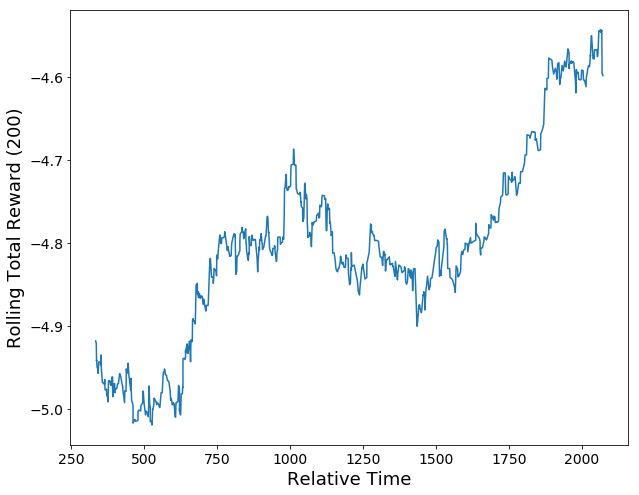

In [28]:
df_merged = show_reward_plot(RUN, rolling_setting=rolling_setting)

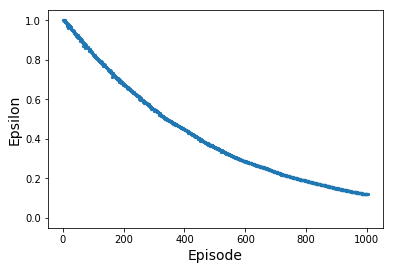

In [29]:
plt.scatter(df_merged['episode'], df_merged['epsilon'], s=5)
plt.xlabel('Episode',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.ylim(-0.05,1.05)
plt.show()

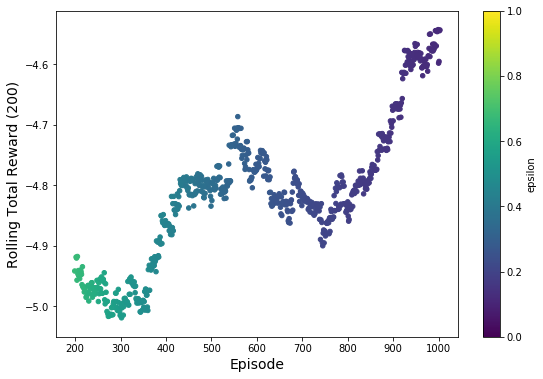

In [30]:
# color plot by epsilon

fig, ax = plt.subplots(figsize=(9,6))
df_merged.plot.scatter('episode', 'total_reward_roll', c='epsilon', cmap='viridis', ax=ax, vmin=0, vmax=1)
plt.ylabel('Rolling Total Reward ({})'.format(rolling_setting), fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.show()

In [ ]:
'''plt.hist(df_merged.loc[df_merged['policy_type']==1]['action'], bins=list(range(0,301)))
plt.ylabel('Count',fontsize=14)
plt.xlabel('Action',fontsize=14)
plt.show()'''

### analysis of rank csvs

In [7]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


In [8]:
header= ['ClusterSize','Rank','Episode','Step','ActionMolecule', 'ActionRotation', 'ActionTranslation', 
         'TTMEnergy','SchNetEnergy','Reward','Done']


df = pd.DataFrame()

for rank_csv in [x for x in os.listdir(os.path.join(RUN, 'EXP000/RUN000/')) if 'csv' in x]:
    if '0' not in rank_csv:
        df_temp = pd.read_csv(os.path.join(RUN, 'EXP000/RUN000/', rank_csv), names=header)
        df = pd.concat([df,df_temp])
    
print(f'{len(df)} total steps taken')

1248 total steps taken


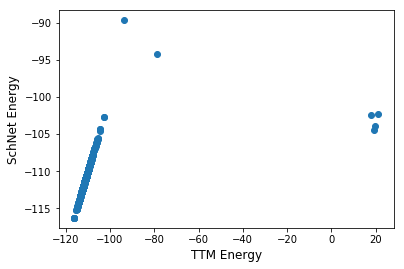

In [9]:
plt.scatter(df.loc[df['SchNetEnergy']!=0]['TTMEnergy'], df.loc[df['SchNetEnergy']!=0]['SchNetEnergy'])
plt.xlabel('TTM Energy', fontsize=12)
plt.ylabel('SchNet Energy', fontsize=12)
plt.show()

In [10]:
df.loc[(df['SchNetEnergy']!=0) & (df['TTMEnergy']>-95)]

,ClusterSize,Rank,Episode,Step,ActionMolecule,ActionRotation,ActionTranslation,TTMEnergy,SchNetEnergy,Reward,Done
14,12,1,5,2,7,91.33,0.6955,21.1925,-102.2346,-4.9953,True
199,12,1,62,2,8,106.17,0.6558,18.1113,-102.4805,-4.9360,True
269,12,1,85,2,5,104.08,0.6865,19.4465,-104.4006,-5.0630,True
28,12,3,10,1,5,104.88,0.6963,19.8753,-103.9729,-4.8647,True
120,12,4,41,1,9,105.51,0.5881,-78.7184,-94.1899,-4.9481,True
203,12,4,70,1,1,97.55,0.5803,-93.4865,-89.6888,-5.1398,True


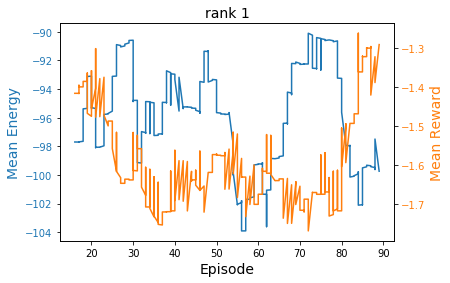

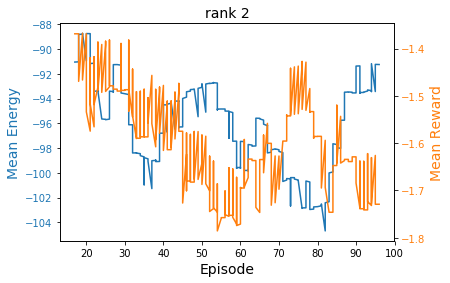

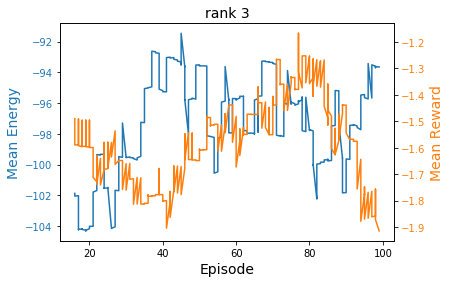

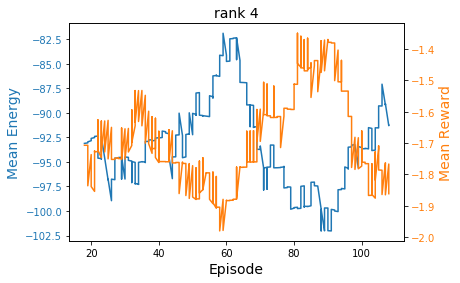

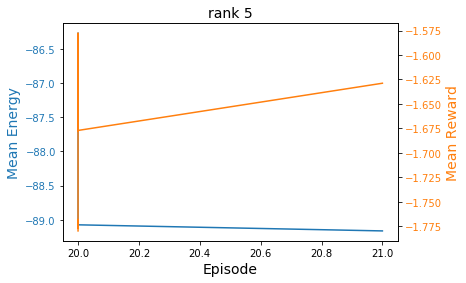

In [11]:
colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']


for name, group in df.groupby('Rank'):

    fig, ax1 = plt.subplots()
    plt.title(f'rank {name}',fontsize=14)
    c1 = colors[0]
    ax2 = ax1.twinx()
    c2 = colors[1]
    ax1.plot(group['Episode'],group['TTMEnergy'].rolling(rolling_setting).mean(),color=c1)    
    ax2.plot(group['Episode'],group['Reward'].rolling(rolling_setting).mean(),color=c2)

    ax1.set_xlabel('Episode',fontsize=14)
    ax1.set_ylabel('Mean Energy',fontsize=14,color=c1)
    ax2.set_ylabel('Mean Reward',fontsize=14,color=c2)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax2.tick_params(axis='y', labelcolor=c2)
    plt.show()

C:\Users\pope044\AppData\Local\Continuum\anaconda3\envs\chemistry\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
C:\Users\pope044\AppData\Local\Continuum\anaconda3\envs\chemistry\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


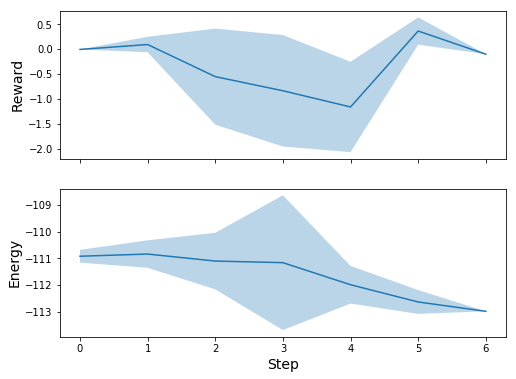

In [12]:
groups=df.groupby(['Rank'])
all_y, all_t = [], []

for r, rank in groups:
    reward = [ep['Reward'].tolist()[:-2] for e, ep in rank.groupby(['Episode'])]
    y, error = tolerant_mean(reward)
    all_y.append(y)
    ttmenergy = [ep['TTMEnergy'].tolist()[:-2] for e, ep in rank.groupby(['Episode'])]
    t_y, t_error = tolerant_mean(ttmenergy)

    all_t.append(t_y)


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,6), sharex=True)
    
all_y=np.array(all_y)
# avg over all ranks
y_mean, y_std= tolerant_mean(all_y)
ax1.plot(range(len(y_mean)), y_mean, label=r)
ax1.fill_between(range(len(y_mean)), y_mean-y_std, y_mean+y_std, alpha=0.3) 
ax1.set_ylabel('Reward', fontsize=14)


all_t=np.array(all_t)
# avg over all ranks
t_mean, t_std= tolerant_mean(all_t)
ax2.plot(range(len(t_mean)), t_mean, label='TTM2.1F')
ax2.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.3)
ax2.set_ylabel('Energy', fontsize=14)
ax2.set_xlabel('Step', fontsize=14)


plt.show()

In [13]:
df.loc[(df['Step']==df['Step'].max())]

,ClusterSize,Rank,Episode,Step,ActionMolecule,ActionRotation,ActionTranslation,TTMEnergy,SchNetEnergy,Reward,Done
57,12,5,20,8,10,119.91,0.6439,-113.0564,-113.0414,-4.9692,True
